In [2]:
import os
from shapely.geometry import Point, Polygon, MultiPolygon
from datetime import datetime
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import sqlite3 as sl
import json
import itertools
import matplotlib.pyplot as plt
import requests

import logging
logging.getLogger().setLevel(logging.INFO) # DEBUG, INFO or WARN

from dotenv import load_dotenv
load_dotenv()

from bing_helper import Bing

DROOT = '../1-data/'
os.makedirs(os.path.join(DROOT, '3-interim', 'populationmasks'), exist_ok=True)

# Transitland Tests

`url = 'https://transit.land/api/v2/rest/feeds'` doesn't work, doesn't filter correctly on distance


In [ ]:
TL_KEY = 'knXH4ILZRhuKjB6Wfn7xNLftEusAt1aJ'

In [17]:
url = 'https://transit.land/api/v2/rest/agencies'
params = {
    "lat": 52.785071,
    "lon": 4.804538,
    "radius": 10000,
    "apikey": TL_KEY
}

response = requests.get(url, params=params)
res = response.json()

feeds = [agency['feed_version'] for agency in res['agencies']]
print(feeds)

feed_ids = [feed['feed']['onestop_id'] for feed in feeds]
feed_ids = list(set(feed_ids))
feed_ids

[{'feed': {'id': 651, 'onestop_id': 'f-u-flixbus'}, 'fetched_at': '2023-05-22T04:00:48.357252Z', 'id': 329979, 'sha1': '30f33ee40fc65198ba02e12142ccda00754db03a'}, {'feed': {'id': 713, 'onestop_id': 'f-u-nl'}, 'fetched_at': '2023-05-27T18:00:41.506574Z', 'id': 331402, 'sha1': '7c68b79eef3c228f7197129ea9c6f47554a9decf'}, {'feed': {'id': 713, 'onestop_id': 'f-u-nl'}, 'fetched_at': '2023-05-27T18:00:41.506574Z', 'id': 331402, 'sha1': '7c68b79eef3c228f7197129ea9c6f47554a9decf'}, {'feed': {'id': 713, 'onestop_id': 'f-u-nl'}, 'fetched_at': '2023-05-27T18:00:41.506574Z', 'id': 331402, 'sha1': '7c68b79eef3c228f7197129ea9c6f47554a9decf'}, {'feed': {'id': 1268, 'onestop_id': 'f-germany~urban~transport'}, 'fetched_at': '2023-05-28T03:00:52.209868Z', 'id': 331485, 'sha1': '894d6fe82e8e644eb534915a123fd7730cb8c7c3'}, {'feed': {'id': 1268, 'onestop_id': 'f-germany~urban~transport'}, 'fetched_at': '2023-05-28T03:00:52.209868Z', 'id': 331485, 'sha1': '894d6fe82e8e644eb534915a123fd7730cb8c7c3'}]


['f-germany~urban~transport', 'f-u-flixbus', 'f-u-nl']

In [18]:
url = 'https://transit.land/api/v2/rest/routes'
params = {
#     "lat": 52.785071,
#     "lon": 4.804538,
#     "radius": 1000,
    "apikey": TL_KEY,
    "vehicle_type": "monorail"
}

response = requests.get(url, params=params)
res = response.json()
res

{'meta': {'after': 154319,
  'next': 'https://transit.land/api/v2/rest/routes?after=154319&apikey=knXH4ILZRhuKjB6Wfn7xNLftEusAt1aJ&vehicle_type=monorail'},
 'routes': [{'agency': {'agency_id': '1',
    'agency_name': 'Azienda Varesina Trasporti',
    'id': 4120,
    'onestop_id': 'o-u0nkbh2-aziendavaresinatrasporti'},
   'continuous_drop_off': None,
   'continuous_pickup': None,
   'feed_version': {'feed': {'id': 69,
     'onestop_id': 'f-u0nkbh2-aziendavaresinatrasporti'},
    'fetched_at': '2016-03-14T20:27:49.554873Z',
    'id': 142,
    'sha1': '36f176346197292795b27e0ba455a2a3ca5d07ad'},
   'id': 154308,
   'onestop_id': 'r-u0nkbh-bf1',
   'route_color': '07624A',
   'route_desc': 'La funicolare Vellone-Sacro Monte opera con frequenza ogni 10 minuti nei giorni feriali e festivi',
   'route_id': 'BF1',
   'route_long_name': 'Vellone - Sacro Monte',
   'route_short_name': 'BF1',
   'route_sort_order': 0,
   'route_text_color': 'FFFFFF',
   'route_type': 7,
   'route_url': 'http://ww

In [ ]:
params = {
    "lat": 52.785071,
    "lon": 4.804538,
    "radius": 100,
    "apikey": TL_KEY
}

response = requests.get(url, params=params)
res = response.json()
res

{'feeds': [{'authorization': {'info_url': '', 'param_name': '', 'type': ''},
   'feed_state': {'feed_version': None},
   'feed_versions': [{'earliest_calendar_date': '2023-04-15',
     'fetched_at': '2023-05-26T02:01:26.484461Z',
     'id': 331045,
     'latest_calendar_date': '2024-03-01',
     'sha1': '95be9ca6441fba980ef16b9f723fe86a32262b87',
     'url': 'http://data.trilliumtransit.com/gtfs/caltrain-ca-us/caltrain-ca-us.zip'},
    {'earliest_calendar_date': '2023-04-15',
     'fetched_at': '2023-04-27T22:00:45.058221Z',
     'id': 324403,
     'latest_calendar_date': '2024-03-01',
     'sha1': '2dc9e879ae64a694e6cd317ec5eca4757eb1e847',
     'url': 'http://data.trilliumtransit.com/gtfs/caltrain-ca-us/caltrain-ca-us.zip'},
    {'earliest_calendar_date': '2023-04-15',
     'fetched_at': '2023-04-21T00:00:45.371384Z',
     'id': 322817,
     'latest_calendar_date': '2024-03-01',
     'sha1': '6ebf031f368f1167703dfdfd65a70edffdaf14da',
     'url': 'http://data.trilliumtransit.com/gtfs

# Valhalla Tests

In [7]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/113.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'ca',
    # 'Accept-Encoding': 'gzip, deflate, br',
    'Origin': 'https://valhalla.openstreetmap.de',
    'Connection': 'keep-alive',
    'Referer': 'https://valhalla.openstreetmap.de/',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-site',
    'DNT': '1',
    'Pragma': 'no-cache',
    'Cache-Control': 'no-cache',
}

response = requests.get(
    'http://localhost:8002/isochrone?json=%7B%22costing%22:%22auto%22,%22costing_options%22:%7B%22car%22:%7B%22exclude_polygons%22:[],%22maneuver_penalty%22:5,%22country_crossing_penalty%22:0,%22country_crossing_cost%22:600,%22width%22:1.6,%22height%22:1.9,%22use_highways%22:1,%22use_tolls%22:1,%22use_ferry%22:1,%22ferry_cost%22:300,%22use_living_streets%22:0.5,%22use_tracks%22:0,%22private_access_penalty%22:450,%22ignore_closures%22:false,%22closure_factor%22:9,%22service_penalty%22:15,%22service_factor%22:1,%22exclude_unpaved%22:1,%22shortest%22:false,%22exclude_cash_only_tolls%22:false,%22top_speed%22:140,%22fixed_speed%22:0,%22toll_booth_penalty%22:0,%22toll_booth_cost%22:15,%22gate_penalty%22:300,%22gate_cost%22:30,%22include_hov2%22:false,%22include_hov3%22:false,%22include_hot%22:false%7D%7D,%22contours%22:[%7B%22time%22:10%7D],%22locations%22:[%7B%22lon%22:1.5212467,%22lat%22:42.5069391,%22type%22:%22break%22%7D],%22directions_options%22:%7B%22units%22:%22kilometers%22%7D,%22id%22:%22valhalla_isochrones_lonlat_1.5212467,42.5069391_range_10_interval_10%22%7D',
    headers=headers,
)
response.json()

{'id': 'valhalla_isochrones_lonlat_1.5212467,42.5069391_range_10_interval_10',
 'features': [{'properties': {'fill-opacity': 0.33,
    'fillColor': '#bf4040',
    'opacity': 0.33,
    'fill': '#bf4040',
    'fillOpacity': 0.33,
    'color': '#bf4040',
    'contour': 10,
    'metric': 'time'},
   'geometry': {'coordinates': [[1.492247, 42.565003],
     [1.491649, 42.564939],
     [1.492172, 42.564864],
     [1.492195, 42.563888],
     [1.493921, 42.563614],
     [1.494978, 42.561939],
     [1.49484, 42.560346],
     [1.494131, 42.560055],
     [1.494, 42.559186],
     [1.493194, 42.558939],
     [1.493247, 42.557443],
     [1.493361, 42.558825],
     [1.494331, 42.558855],
     [1.494589, 42.559597],
     [1.496247, 42.560664],
     [1.501247, 42.560501],
     [1.502912, 42.558605],
     [1.504552, 42.558244],
     [1.504665, 42.555939],
     [1.505514, 42.555207],
     [1.505832, 42.553524],
     [1.509827, 42.549519],
     [1.511551, 42.548939],
     [1.511586, 42.5466],
     [1.50996

In [3]:
url = "https://transit.land/api/v2/rest/agencies" 
params = {
    'radius': '10000',
    'lat': '50.767943',
    'lon': '6.089667',
    'apikey': 'knXH4ILZRhuKjB6Wfn7xNLftEusAt1aJ'
}

response = requests.get(url, params=params)
response_json = response.json()

In [4]:
response_json

{'agencies': [{'agency_email': '',
   'agency_fare_url': 'https://www.blablacar.co.uk/bus?comuto_cmkt=UK_GMAPS-PRO_ALL_ALL&utm_medium=Partnership&utm_source=Gmaps&utm_campaign=UK_GMAPS-PRO_ALL_ALL',
   'agency_id': '29',
   'agency_lang': 'en',
   'agency_name': 'BlaBlaCar Bus',
   'agency_phone': '09 69 32 33 48',
   'agency_timezone': 'Europe/Amsterdam',
   'agency_url': 'https://www.blablacar.co.uk/bus?comuto_cmkt=UK_GMAPS-PRO_ALL_ALL&utm_medium=Partnership&utm_source=Gmaps&utm_campaign=UK_GMAPS-PRO_ALL_ALL',
   'feed_version': {'feed': {'id': 214, 'onestop_id': 'f-u0-ouibus'},
    'fetched_at': '2021-10-18T01:06:42.745872Z',
    'id': 235799,
    'sha1': 'd42b6f811263732ce2ef5be6c9d43136ded63422'},
   'geometry': {'coordinates': [[[2.380160747, 48.83568689],
      [3.076675, 50.638756],
      [4.325712, 52.07986],
      [4.838527, 52.389633],
      [6.566261800000007, 53.2116628],
      [10.011099, 53.552107],
      [13.279761, 52.507446],
      [2.380160747, 48.83568689]]],
    't

In [25]:
cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities.head(5)

,City,ctr_name,ctr_lat,ctr_lon,cells,Country,ID_HDC_G0
0,Vienna,Rathaus Wien,48.21080,16.35784,4381,AUT,3027
1,Graz,Hauptplatz Graz,47.06955,15.43383,1168,AUT,3000
2,Brussels,Brussels Town hall,50.84642,4.35232,3747,BEL,2135
3,Berlin,Old City Hall,52.51687,13.41160,5187,DEU,2851
4,Hamburg,Rathaus,53.55035,9.99232,4912,DEU,2531


In [1]:
for i, city in cities.iterrows():
    break;
    print(city.City)
    file = f'{city.ID_HDC_G0}.pcl'
    df = pd.read_pickle(os.path.join(DROOT, '3-interim', 'populationmasks', file))
    gdf = gpd.GeoDataFrame(df)
    
    origins  = enumerate(gdf.centroid.to_crs("EPSG:4326"))
    times    = [5, 15, 25, 35, 45]
    modes_dt = [
        ('driving', 'driving-free', datetime(2023, 5, 2, 8, 30, 37)), 
#         ('driving', 'driving',      datetime(2023, 5, 2, 13, 0, 37)), 
#       ('transit', 'transit-peak', datetime(2023, 5, 2, 8, 30, 37)),
#       ('transit', 'transit',      datetime(2023, 5, 2, 13, 0, 37)), 
#       ('walking', 'walking',      datetime(2023, 5, 2, 8, 30, 37))
    ]
    
    batch      = list(itertools.product(origins, times, modes_dt))
    isochrones = client.get_isochrones_async(city.ID_HDC_G0, batch)

NameError: name 'cities' is not defined

{     "features": [         {             "properties": {                 "fill": "#bf4040",                 "fillOpacity": 0.33,                 "fill-opacity": 0.33,                 "fillColor": "#bf4040",                 "color": "#bf4040",                 "contour": 40,                 "opacity": 0.33,                 "metric": "time"             },             "geometry": {                 "coordinates": [                     [                         6.099667,                         50.787707                     ],                     [                         6.094168,                         50.787442                     ],                     [                         6.093667,                         50.785735                     ],                     [                         6.091525,                         50.785801                     ],                     [                         6.091126,                         50.787401                     ],                     

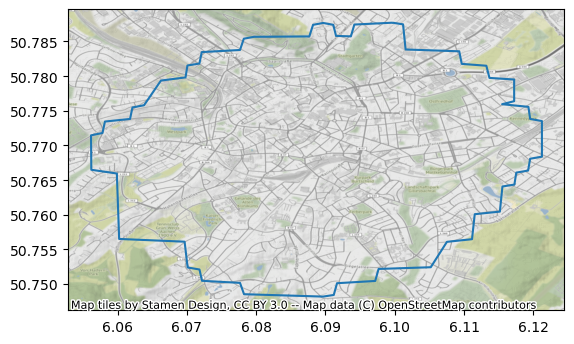

In [11]:
somedata = json.loads(input())
gdf = gpd.GeoDataFrame.from_features(somedata, crs='EPSG:4326')
ax = gdf.plot()
ctx.add_basemap(ax, crs=gdf.crs)

In [18]:
polygons = []
for l1 in coords:
    for l2 in l1['coordinates']:
        polygons.append(Polygon([[e[1], e[0]] for e in l2]))
result = gpd.GeoSeries(MultiPolygon(polygons)).set_crs("EPSG:4326")

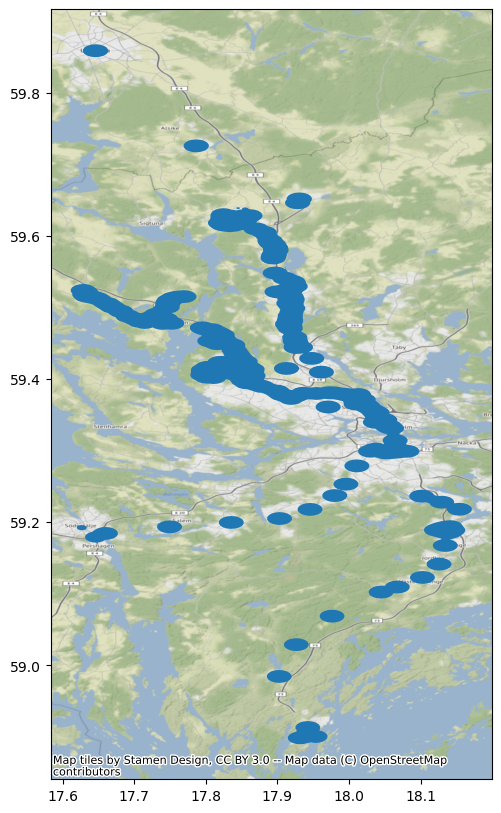

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
result.plot(ax=ax)
ctx.add_basemap(ax, crs=result.crs)